## Librerías necesarias 

## Preprocesamiento de los datos
✅ Aplica CLAHE, resize (224×224), padding, normalización y conversión a RGB.

✅ Luego crea generadores (train_generator y val_generator) listos para pasar a tu modelo EfficientNet.

In [8]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))



TensorFlow: 2.20.0
GPUs: []


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12592021495995689236
xla_global_id: -1
]


In [3]:
# ============================================================
# 🧠 ENTRENAMIENTO DE CLASIFICADOR MULTICLASE CON EFFICIENTNETB0
# ============================================================

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ============================================================
# 📂 CONFIGURACIÓN DE RUTAS
# ============================================================

# Ruta principal que contiene las 4 carpetas de categorías
base_dir = r"C:\Users\alejo\OneDrive\Documents\Universidad\Maestria\Deep learning\2. copia git\Caso2\COVID-19_Radiography_Dataset"
IMG_SIZE = 224
TEST_SIZE = 0.2
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-4

# CLAHE params
CLAHE_CLIP = 2.0
CLAHE_GRID = (8, 8)

# ============================================================
# FUNCIONES AUXILIARES
# ============================================================
def apply_clahe_and_resize_gray(path, img_size=IMG_SIZE, clip=CLAHE_CLIP, grid=CLAHE_GRID):
    """
    Lee imagen en grayscale, aplica CLAHE, redimensiona manteniendo aspecto con padding,
    devuelve imagen uint8 en escala 0-255 (single-channel).
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"No se pudo leer: {path}")

    # Aplicar CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=grid)
    enhanced = clahe.apply(img)

    # Resize manteniendo aspecto y padding centrado
    h, w = enhanced.shape
    scale = img_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(enhanced, (new_w, new_h), interpolation=cv2.INTER_AREA)

    padded = np.zeros((img_size, img_size), dtype=np.uint8)
    x_offset = (img_size - new_w) // 2
    y_offset = (img_size - new_h) // 2
    padded[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized

    return padded  # uint8 (0-255), single channel


def gray_to_rgb_stack(gray_img):
    """
    Convierte imagen (H,W) uint8 a (H,W,3) replicando el canal.
    """
    if gray_img.ndim == 2:
        return np.stack((gray_img,)*3, axis=-1)
    elif gray_img.ndim == 3 and gray_img.shape[2] == 1:
        return np.concatenate([gray_img]*3, axis=-1)
    else:
        return gray_img  # ya RGB
    

In [4]:
# ============================================================
# CONSTRUIR DATAFRAME con rutas e etiquetas (categorías)
# ============================================================
data = []
for category in sorted(os.listdir(base_dir)):
    category_path = os.path.join(base_dir, category)
    images_dir = os.path.join(category_path, "images")
    if not os.path.isdir(images_dir):
        print(f"⚠️ No se encontró 'imagenes' en {category_path}, se omite")
        continue
    for fn in sorted(os.listdir(images_dir)):
        if fn.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
            data.append({"ruta_imagen": os.path.join(images_dir, fn), "categoria": category})

df = pd.DataFrame(data)
if df.empty:
    raise SystemExit("No se encontraron imágenes. Revisa base_dir y estructura de carpetas.")
print(f"✅ Dataset creado: {len(df)} imágenes, {df['categoria'].nunique()} clases")
print(df['categoria'].value_counts())


⚠️ No se encontró 'imagenes' en C:\Users\alejo\OneDrive\Documents\Universidad\Maestria\Deep learning\2. copia git\Caso2\COVID-19_Radiography_Dataset\COVID.metadata.xlsx, se omite
⚠️ No se encontró 'imagenes' en C:\Users\alejo\OneDrive\Documents\Universidad\Maestria\Deep learning\2. copia git\Caso2\COVID-19_Radiography_Dataset\Lung_Opacity.metadata.xlsx, se omite
⚠️ No se encontró 'imagenes' en C:\Users\alejo\OneDrive\Documents\Universidad\Maestria\Deep learning\2. copia git\Caso2\COVID-19_Radiography_Dataset\Normal.metadata.xlsx, se omite
⚠️ No se encontró 'imagenes' en C:\Users\alejo\OneDrive\Documents\Universidad\Maestria\Deep learning\2. copia git\Caso2\COVID-19_Radiography_Dataset\README.md.txt, se omite
⚠️ No se encontró 'imagenes' en C:\Users\alejo\OneDrive\Documents\Universidad\Maestria\Deep learning\2. copia git\Caso2\COVID-19_Radiography_Dataset\Viral Pneumonia.metadata.xlsx, se omite
✅ Dataset creado: 21165 imágenes, 4 clases
categoria
Normal             10192
Lung_Opacity   

In [5]:
# ============================================================
# MAPEO DE CLASES Y CARGA + PREPROCESAMIENTO (CLAHE + STACK + preprocess_input)
# ============================================================
class_names = sorted(df["categoria"].unique())
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
print("Clases:", class_to_idx)

X_list, y_list = [], []
for idx, row in df.iterrows():
    p = row["ruta_imagen"]
    label = class_to_idx[row["categoria"]]
    try:
        gray = apply_clahe_and_resize_gray(p, img_size=IMG_SIZE)
        rgb = gray_to_rgb_stack(gray)                     # -> H,W,3 uint8
        X_list.append(rgb)
        y_list.append(label)
    except Exception as e:
        print(f"⚠️ Error cargando {p}: {e}")

X = np.array(X_list, dtype=np.uint8)   # shape (N, H, W, 3) uint8
y = np.array(y_list, dtype=np.int32)

print(f"✅ Imágenes cargadas en memoria: {X.shape}, etiquetas: {y.shape}")


Clases: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
✅ Imágenes cargadas en memoria: (21165, 224, 224, 3), etiquetas: (21165,)


In [6]:
# ============================================================
# NORMALIZACIÓN: usar preprocess_input (EfficientNet espera [-1,1])
# ============================================================
# Convertir a float32 primero
X = X.astype(np.float32)
X = preprocess_input(X)   # esto ajusta según EfficientNet (usa escala -1..1)
y_cat = to_categorical(y, num_classes=len(class_names))

In [7]:
# ============================================================
# SPLIT TRAIN/TEST
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=TEST_SIZE, random_state=42, stratify=y_cat
)
print(f"Split: train={X_train.shape[0]}, test={X_test.shape[0]}")

# ============================================================
# DATA AUGMENTATION
# ============================================================
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


Split: train=16932, test=4233


In [9]:
# ============================================================
# LIMPIAR SESSION PREVIA (evita cargar pesos antiguos inconsistentes)
# ============================================================
tf.keras.backend.clear_session()

# ============================================================
# MODELO: EfficientNetB0 (INPUT 3 CANALES) - clave: input_shape=(224,224,3)
# ============================================================

# Instanciar sin pesos primero
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Descargar y cargar pesos manualmente
weights_url = "https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5"
weights_path = tf.keras.utils.get_file("efficientnetb0_notop.h5", origin=weights_url, cache_subdir="models")
base_model.load_weights(weights_path)

# Congelar base (igual que antes)
for layer in base_model.layers:
    layer.trainable = False

# Agregar top personalizado (igual que antes)
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compilar (igual que antes)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

print("\nResumen del modelo (asegúrate INPUT 3 canales):")
model.summary()


Resumen del modelo (asegúrate INPUT 3 canales):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 20,107,175 (76.70 MB)

 Trainable params: 16,057,604 (61.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
# ============================================================
# CALLBACKS
# ============================================================
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, mode='max', restore_best_weights=True, verbose=1)
lr_plateau = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# ============================================================
# ENTRENAMIENTO
# ============================================================
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_plateau],
    verbose=1
)


Epoch 1/50


c:\Users\alejo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1059/1059 ━━━━━━━━━━━━━━━━━━━━ 223s 206ms/step - accuracy: 0.7926 - loss: 0.5617 - val_accuracy: 0.8311 - val_loss: 0.4431 - learning_rate: 1.0000e-04
Epoch 2/50
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 210s 198ms/step - accuracy: 0.8444 - loss: 0.4222 - val_accuracy: 0.8656 - val_loss: 0.3472 - learning_rate: 1.0000e-04
Epoch 3/50
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 212s 200ms/step - accuracy: 0.8558 - loss: 0.3835 - val_accuracy: 0.7940 - val_loss: 0.5324 - learning_rate: 1.0000e-04
Epoch 4/50
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 220s 207ms/step - accuracy: 0.8674 - loss: 0.3542 - val_accuracy: 0.8677 - val_loss: 0.3565 - learning_rate: 1.0000e-04
Epoch 5/50
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 218s 206ms/step - accuracy: 0.8719 - loss: 0.3439 - val_accuracy: 0.8481 - val_loss: 0.3809 - learning_rate: 1.0000e-04
Epoch 6/50
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 208s 196ms/step - accuracy: 0.8751 - loss: 0.3285 - val_accuracy: 0.8736 - val_loss: 0.3335 - learning_rate: 1.0000e-04
Epoch 7/50
1059/1059 ━━━━━━━━━━━━━━━━━━


🎯 Precisión en test: 90.69%


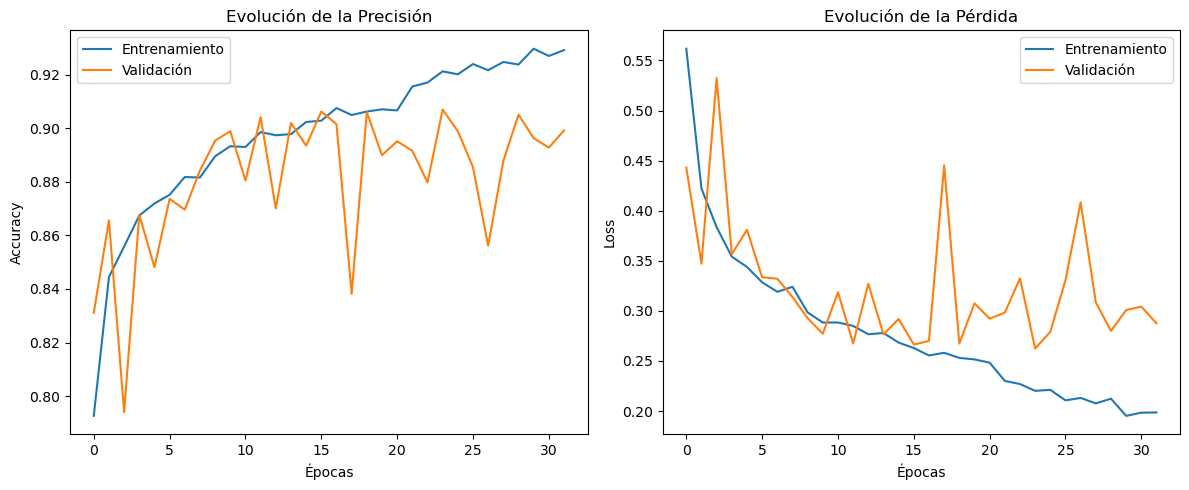

133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step


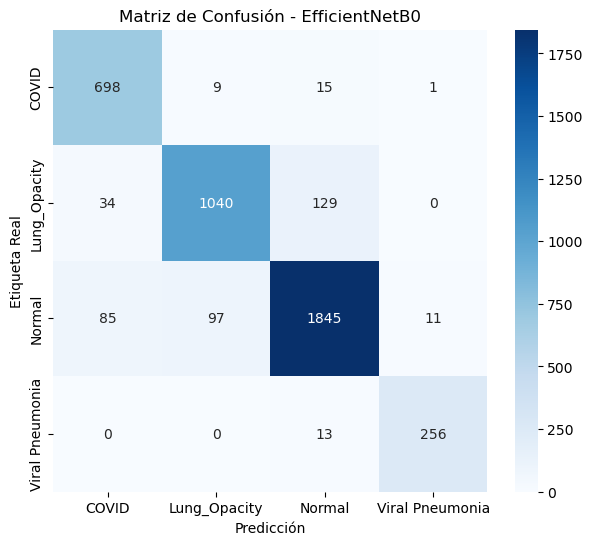

In [11]:
# ============================================================
# EVALUACIÓN Y GRAFICAS
# ============================================================
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n🎯 Precisión en test: {acc*100:.2f}%")

# Curvas
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución de la Precisión')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Matriz de confusión
y_pred = model.predict(X_test)
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión - EfficientNetB0")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()
